# Loading Data to VM and setting up the notebook

In [2]:
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt, tqdm, json, os, math

ROOT = Path("data/lmd_matched").expanduser()
midi_files = sorted(ROOT.rglob("*.mid")) + sorted(ROOT.rglob("*.midi"))
print("Number of MIDIs:", len(midi_files))
print("Here are three examples:", midi_files[:3])

Number of MIDIs: 116189
Here are three examples: [WindowsPath('data/lmd_matched/A/A/A/TRAAAGR128F425B14B/1d9d16a9da90c090809c153754823c2b.mid'), WindowsPath('data/lmd_matched/A/A/A/TRAAAGR128F425B14B/5dd29e99ed7bd3cc0c5177a6e9de22ea.mid'), WindowsPath('data/lmd_matched/A/A/A/TRAAAGR128F425B14B/b97c529ab9ef783a849b896816001748.mid')]


# Basic integrity

## A glimpse into the type of music

the following graph tells us how the models are going to behave according to the given data

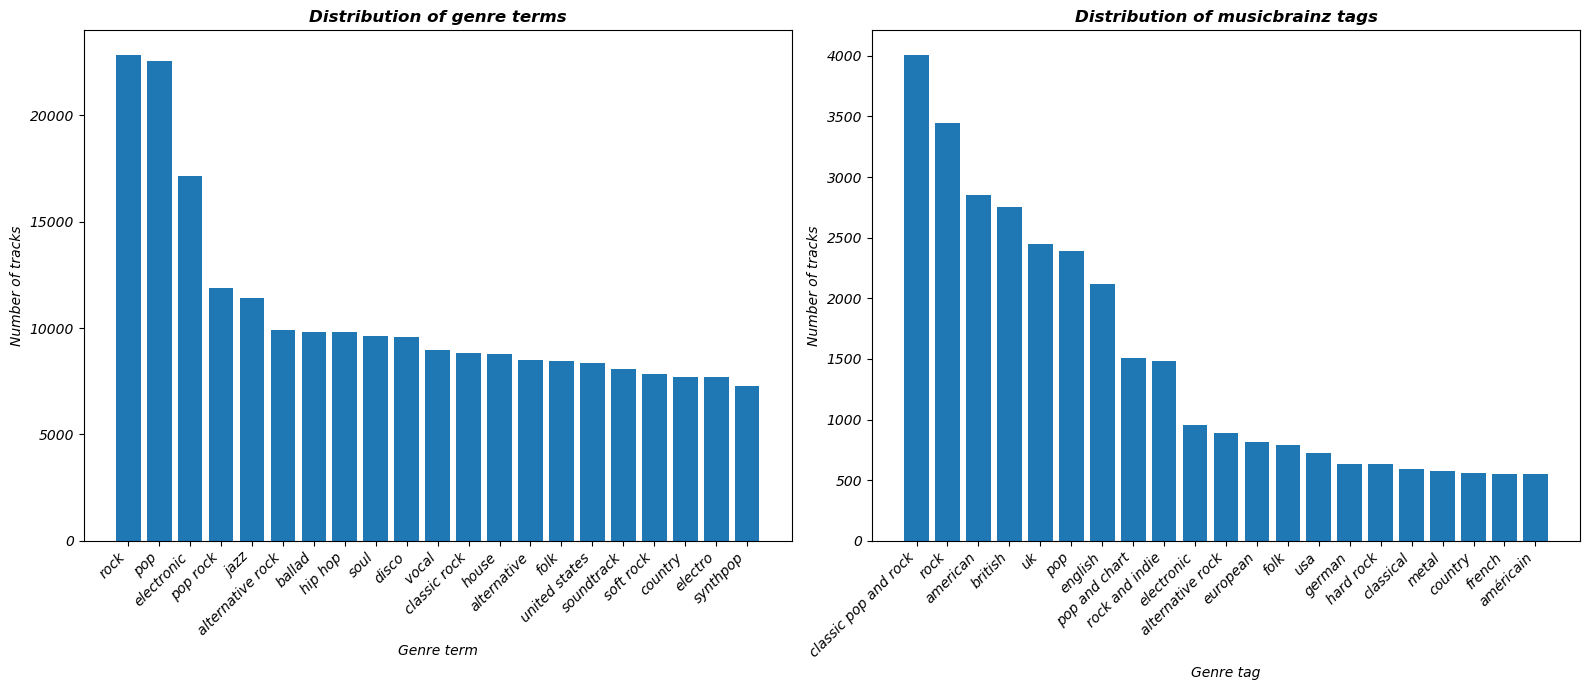

In [2]:
terms_distro = pd.read_csv("data/term_distro.csv", delimiter=",")
mbtags_distro = pd.read_csv("data/mbtag_distro.csv", delimiter=",")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), tight_layout=True)

ax1.bar(terms_distro["genre_term"].loc[:20], terms_distro["n_tracks"].loc[:20])
ax1.set_title("Distribution of genre terms", fontweight="bold")
ax1.set_ylabel("Number of tracks")
ax1.set_xlabel("Genre term")
ax1.tick_params(axis="x", labelrotation=45)
for t in ax1.get_xticklabels():
    t.set_ha("right")

ax2.bar(mbtags_distro["genre_tag"].loc[:20], mbtags_distro["n_tracks"].loc[:20])
ax2.set_title("Distribution of musicbrainz tags", fontweight="bold")
ax2.set_ylabel("Number of tracks")
ax2.set_xlabel("Genre tag")
ax2.tick_params(axis="x", labelrotation=45)
for t in ax2.get_xticklabels():
    t.set_ha("right")
plt.savefig("data_reports/genre_distribution.png", dpi=300)
plt.show()

## Some statistics on a sample from the dataset

In [3]:
import pretty_midi, random, statistics
from tqdm import tqdm

rng = random.Random()
sample = rng.sample(midi_files, k=5000)


def safe_read(p):
    try:
        pm = pretty_midi.PrettyMIDI(str(p))
        return pm
    except Exception as e:
        return None


rows = []
for p in tqdm(sample):
    pm = safe_read(p)
    ok = pm is not None
    dur = pm.get_end_time() if ok else np.nan
    tempos = [] if not ok else [t for t in pm.get_tempo_changes()[1]]
    time_sigs = (
        []
        if not ok
        else [(ts.numerator, ts.denominator) for ts in pm.time_signature_changes]
    )
    n_notes = 0 if not ok else sum(len(i.notes) for i in pm.instruments)
    n_instr = 0 if not ok else len(set([i.program for i in pm.instruments]))
    rows.append(
        dict(
            path=str(p),
            ok=ok,
            duration=dur,
            notes=n_notes,
            instruments=n_instr,
            tempi=len(tempos),
            time_sigs=len(time_sigs),
        )
    )
df_basic = pd.DataFrame(rows)

  0%|          | 18/5000 [00:02<11:39,  7.12it/s]c:\ProgramData\anaconda3\envs\bachelor-thesis\lib\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
100%|██████████| 5000/5000 [11:48<00:00,  7.06it/s]


### Creating the report

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df_basic, title="Data Report", explorative=True)
profile.to_notebook_iframe() # open in your browser
profile.to_file("data_reports/basic_info.html")


# Claculating some metrics

In [ ]:
from collections import Counter
import muspy
# --- setup tallies ---
prog_ctr, drum_ctr = Counter(), 0
all_pitches = []          
rows = []

for p in tqdm(sample):
    pm = safe_read(p)
    if not pm:
        continue

    # per-instrument bookkeeping (from PrettyMIDI side)
    for inst in pm.instruments:
        if inst.is_drum:
            drum_ctr += 1
        else:
            prog_ctr[inst.program] += 1
        # collect all pitches for global stats
        all_pitches.extend(n.pitch for n in inst.notes)

    # switch to MusPy for metrics
    m = muspy.from_pretty_midi(pm)

    # --- measure resolution (robust) ---
    def safe_measure_resolution(m):
        # first valid TS (denominator > 0)
        ts = next((ts for ts in m.time_signatures if getattr(ts, "denominator", 0) > 0), None)
        if ts is None:
            num, den = 4, 4
        else:
            num, den = ts.numerator, ts.denominator
            if den <= 0:
                den = 4
        # resolution (ticks/qn) * (num beats per measure) * (4/den) to normalize to quarter=1
        return int(round(m.resolution * num * 4 / den))

    measure_resolution = safe_measure_resolution(m)

    # --- counts & duration ---
    total_notes = sum(len(t.notes) for t in m.tracks)
    non_drum_notes = [n for t in m.tracks if not t.is_drum for n in t.notes]
    drum_notes = [n for t in m.tracks if t.is_drum for n in t.notes]

    # whole-piece duration in ticks (MusPy)
    dur_ticks = m.get_end_time() or 0
    beat = m.resolution
    dur_seconds = pm.get_end_time() or 0.0  

    # --- validity & hygiene ---
    def overlaps_same_pitch(track):
        bad = 0
        # already ordered per pitch by time thanks to key sort:
        notes = sorted(track.notes, key=lambda x: (x.pitch, x.time, x.end))
        by_pitch = {}
        for n in notes:
            by_pitch.setdefault(n.pitch, []).append((n.time, n.end))
        for spans in by_pitch.values():
            last_end = -1
            for t0, t1 in spans:
                if t0 < last_end:
                    bad += 1
                if t1 > last_end:
                    last_end = t1
        return bad

    same_pitch_overlap_count = sum(overlaps_same_pitch(t) for t in m.tracks if not t.is_drum)
    ts_changes = max(len(m.time_signatures) - 1, 0)
    parsable_nonempty = int(total_notes > 0 and dur_seconds > 0)

    # --- tempo stats ---
    # optional: dedup consecutive tempo qpm values at the same time
    tempos = m.tempos
    if tempos:
        # (time, qpm) sorted; drop exact duplicates by (time,qpm)
        seen = set()
        uniq = []
        for tm in sorted(tempos, key=lambda x: getattr(x, "time", 0)):
            key = (getattr(tm, "time", 0), tm.qpm)
            if key not in seen:
                uniq.append(tm)
                seen.add(key)
        bpms = [tm.qpm for tm in uniq]
    else:
        bpms = []

    tempo_mean_bpm = (sum(bpms) / len(bpms)) if bpms else float("nan")
    tempo_std_bpm = ((sum((x - tempo_mean_bpm) ** 2 for x in bpms) / len(bpms)) ** 0.5) if len(bpms) > 1 else 0.0
    tempo_changes = max(len(bpms) - 1, 0)

    # --- grid alignment (16ths) ---
    grid16 = max(int(round(beat / 4)), 1)
    off = sum((n.time % grid16) != 0 for t in m.tracks for n in t.notes)
    offgrid_rate_16 = off / max(total_notes, 1)

    # --- measure counts & density variance ---
    length_ticks = m.get_end_time() or 0
    n_measures = int(length_ticks // measure_resolution) + (1 if length_ticks > 0 else 0)
    counts_per_measure = [
        sum(1 for t in m.tracks for n in t.notes if (n.time // measure_resolution) == k)
        for k in range(n_measures)
    ]
    if counts_per_measure:
        mean_c = sum(counts_per_measure) / len(counts_per_measure)
        onset_density_var_meas = sum((c - mean_c) ** 2 for c in counts_per_measure) / len(counts_per_measure)
    else:
        onset_density_var_meas = float("nan")

    # --- dynamics (non-drum) ---
    vels = [n.velocity for n in non_drum_notes]
    if vels:
        sv = sorted(vels)
        def pct(sv, p):  # simple nearest-rank percentile
            k = max(0, min(len(sv)-1, int(round(p * (len(sv)-1)))))
            return sv[k]
        v_mean = sum(sv) / len(sv)
        velocity_mean = v_mean
        velocity_std = (sum((v - v_mean) ** 2 for v in sv) / len(sv)) ** 0.5
        velocity_p95_minus_p5 = pct(sv, 0.95) - pct(sv, 0.05)
    else:
        velocity_mean = velocity_std = velocity_p95_minus_p5 = float("nan")

    # --- articulation ---
    # average note duration in beats:
    articulation_beats = (sum(n.duration for t in m.tracks for n in t.notes) / max(total_notes * beat, 1)) if total_notes else float("nan")

    # --- instrumentation & meta ---
    track_count = len(m.tracks)
    drum_note_ratio = len(drum_notes) / max(total_notes, 1)
    pitch_register_mean = (sum(n.pitch for n in non_drum_notes) / len(non_drum_notes)) if non_drum_notes else float("nan")
    length_measures = n_measures

    rows.append(dict(
        path=str(p),
        polyphony=muspy.metrics.polyphony(m),
        polyphony_rate=muspy.metrics.polyphony_rate(m),
        # per-second density (uses PrettyMIDI seconds):
        notes_density=total_notes / max(dur_seconds, 1e-6),
        empty_beat_rate=muspy.metrics.empty_beat_rate(m),
        empty_measure_rate=muspy.metrics.empty_measure_rate(m, measure_resolution),
        groove_consistency=muspy.metrics.groove_consistency(m, measure_resolution),
        n_pitch_classes_used=muspy.metrics.n_pitch_classes_used(m),
        n_pitches_used=muspy.metrics.n_pitches_used(m),
        pitch_class_entropy=muspy.metrics.pitch_class_entropy(m),
        pitch_entropy=muspy.metrics.pitch_entropy(m),
        pitch_range=muspy.metrics.pitch_range(m),
        scale_consistency=muspy.metrics.scale_consistency(m),
        same_pitch_overlap_count=same_pitch_overlap_count,
        time_signature_changes=ts_changes,
        parsable_nonempty=parsable_nonempty,
        tempo_mean_bpm=tempo_mean_bpm,
        tempo_std_bpm=tempo_std_bpm,
        tempo_changes=tempo_changes,
        offgrid_rate_16=offgrid_rate_16,
        onset_density_var_meas=onset_density_var_meas,
        velocity_mean=velocity_mean,
        velocity_std=velocity_std,
        velocity_p95_minus_p5=velocity_p95_minus_p5,
        articulation_avg_beats=articulation_beats,  # renamed for clarity
        drum_note_ratio=drum_note_ratio,
        pitch_register_mean=pitch_register_mean,
        length_measures=length_measures,
        track_count=track_count,
    ))
# build df
df_metrics = pd.DataFrame(rows)

# global pitch stats over all notes:
pd.Series(all_pitches).describe(), prog_ctr.most_common(10), drum_ctr


## Generating the report

In [ ]:
profile = ProfileReport(df_metrics, title="Metrics Report", explorative=True)
profile.to_notebook_iframe() # open in your browser
profile.to_file("data_reports/metrics.html")

## Correlation matrix

### 🔥 Strongest Correlations

#### Near-duplicates
- **Tempo-related**
  - `tempo_changes ↔ tempo_std_bpm` **0.954**  
    More tempo changes → higher tempo variability.
- **Dynamics-related**
  - `velocity_p95_minus_p5 ↔ velocity_std` **0.951**  
    Both measure spread of dynamics.
- **Sparsity-related**
  - `empty_beat_rate ↔ empty_measure_rate` **0.863**  
    Sparse beats go with sparse measures.
- **Pitch/tonal clarity**
  - `pitch_class_entropy ↔ scale_consistency` **−0.848**  
    More tonal ambiguity → less scale consistency.
- **Pitch diversity**
  - `n_pitches_used ↔ pitch_entropy` **0.798**  
    More unique pitches → higher pitch entropy.
- **Texture**
  - `polyphony ↔ polyphony_rate` **0.790**  
    Essentially the same concept.

---

### 🎵 Pitch & Harmony Cluster
- `n_pitch_classes_used ↔ n_pitches_used` **0.764**
- `pitch_class_entropy ↔ pitch_entropy` **0.759**
- `n_pitch_classes_used ↔ pitch_class_entropy` **0.693**
- `n_pitches_used ↔ pitch_class_entropy` **0.692**
- `n_pitches_used ↔ scale_consistency` **−0.650**
- `n_pitches_used ↔ pitch_range` **0.638**
- `pitch_entropy ↔ scale_consistency` **−0.635**

**Interpretation:**  
Greater pitch variety leads to higher entropy, wider pitch range, and weaker adherence to a single scale.

---

### 🥁 Rhythm & Tightness
- `groove_consistency ↔ offgrid_rate_16` **−0.721**  
  More off-grid 16ths → lower groove consistency.
- `notes_density ↔ onset_density_var_meas` **0.622**  
  Denser textures → greater onset variance.
- `articulation_ratio ↔ notes_density` **−0.527**  
  Dense notes → shorter articulations.

---

### ⏱️ Tempo & Length
- `length_measures ↔ tempo_mean_bpm` **0.536**  
  Longer pieces → higher mean BPM (dataset-specific effect).
- `notes_density ↔ tempo_mean_bpm` **0.442**  
  Faster tempos → denser textures.

---

### 🎼 Polyphony & Articulation
- `articulation_ratio ↔ polyphony_rate` **0.506**
- `articulation_ratio ↔ polyphony` **0.425**  

**Interpretation:**  
Higher note overlap (polyphony) is associated with longer articulations.

---

### 📌 Practical Takeaways

#### Feature Selection
To reduce **multicollinearity**, drop one from each of these pairs:
- `tempo_changes` vs. `tempo_std_bpm`
- `velocity_p95_minus_p5` vs. `velocity_std`
- `empty_beat_rate` vs. `empty_measure_rate`
- `polyphony` vs. `polyphony_rate`
- Among pitch/tonal measures, keep a compact subset (e.g., `n_pitch_classes_used`, `scale_consistency`, `pitch_entropy`).

#### Latent Factors (useful for PCA or clustering)
- **Tonal variety / ambiguity:** (`pitch_entropy`, `pitch_class_entropy`, `n_pitches_used`, inverse of `scale_consistency`)
- **Rhythmic tightness vs looseness:** (`groove_consistency` vs. `offgrid_rate_16`)
- **Density / energy:** (`notes_density`, `onset_density_var_meas`, `tempo_mean_bpm`)
- **Dynamics spread:** (`velocity_std` or `velocity_p95_minus_p5`)
- **Texture:** (`polyphony`, `polyphony_rate`, linked to `articulation_ratio`)

#### Sanity Check
- Off-grid timing decreases groove consistency (expected).
- More pitch classes reduce tonal stability (expected).
- Denser passages encourage staccato articulation (musically intuitive).

---


# Pianoroll Visualization

In [28]:
import numpy as np
from pypianoroll import read  # read() is the recommended loader
import matplotlib.pyplot as plt
import pretty_midi as pm

path = str(midi_files[200])

midi = pm.PrettyMIDI(path)
print("Num tracks:", len(midi.instruments))
for i, t in enumerate(midi.instruments):
    print(f"{i}: name={pm.instrument_name_to_program(t.program)}, program={t.program}, is_drum={t.is_drum} ")

mt = read(path)
n = len(mt.tracks)
mt.plot(mode='hybrid')       # pass the axes in; mt.plot() returns the same axes array
plt.gcf().set_size_inches(40, 0.9 * len(mt.tracks) + 2)  # widen + scale height to tracks
plt.tight_layout()
plt.show()


Num tracks: 16


TypeError: 'numpy.int32' object is not iterable

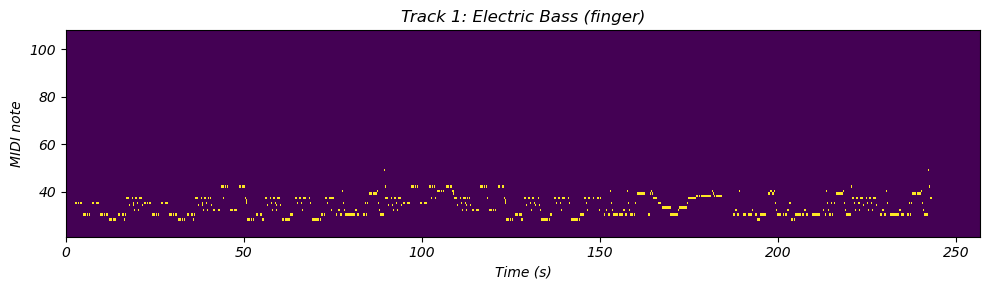

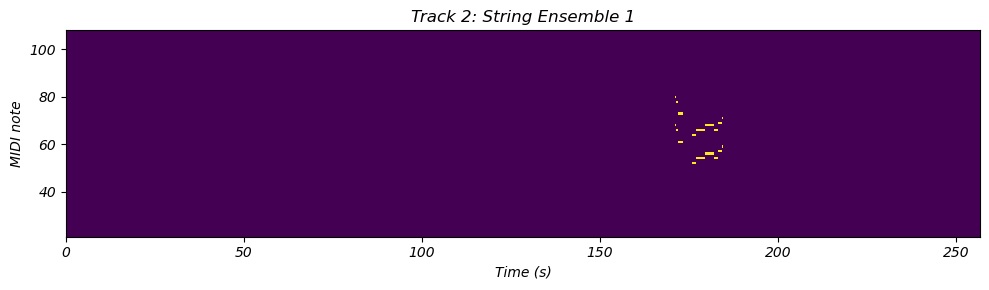

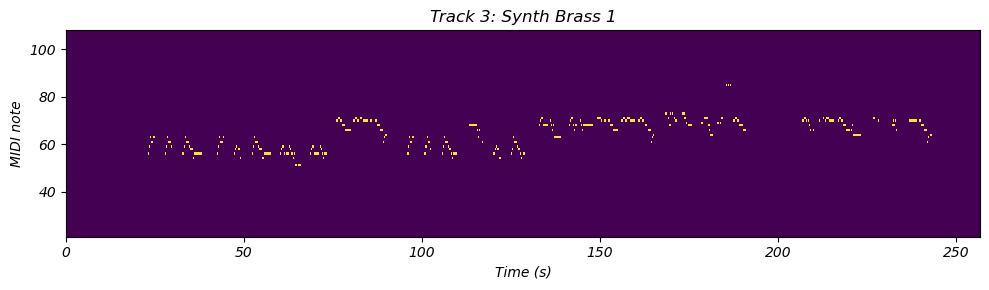

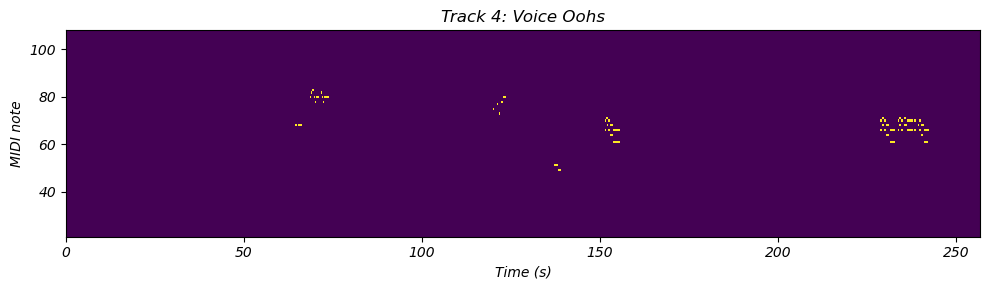

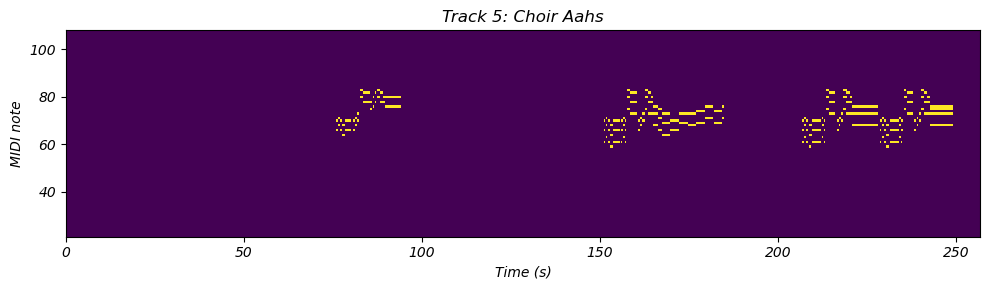

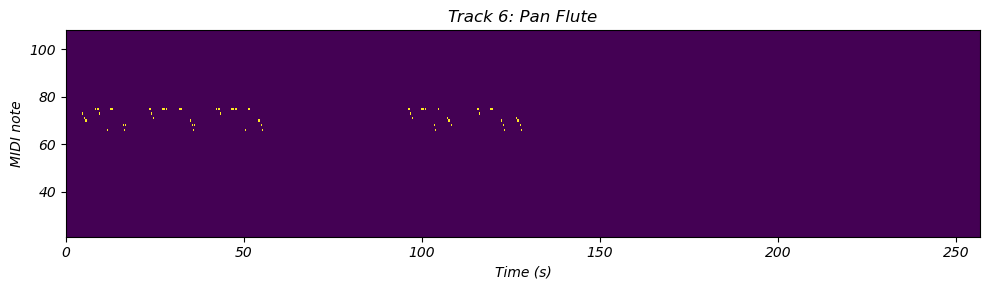

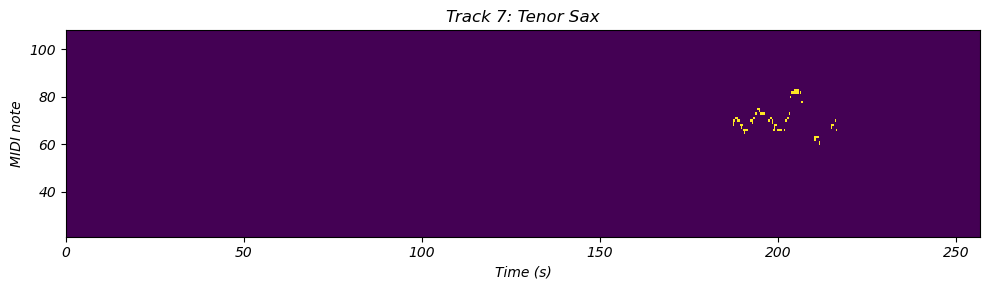

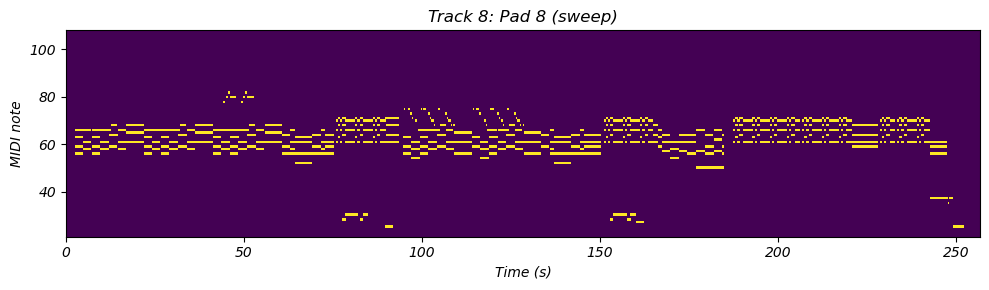

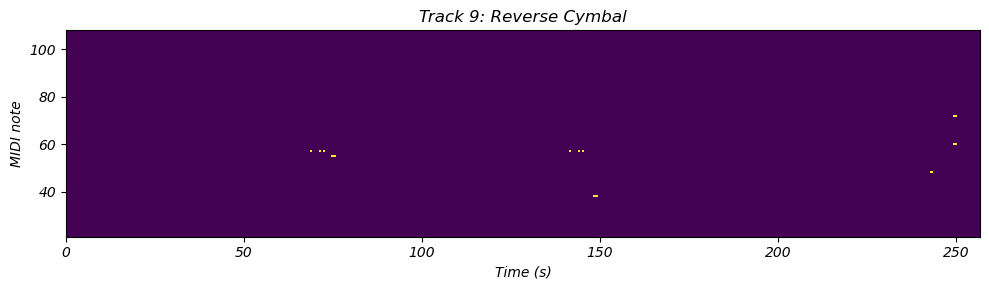

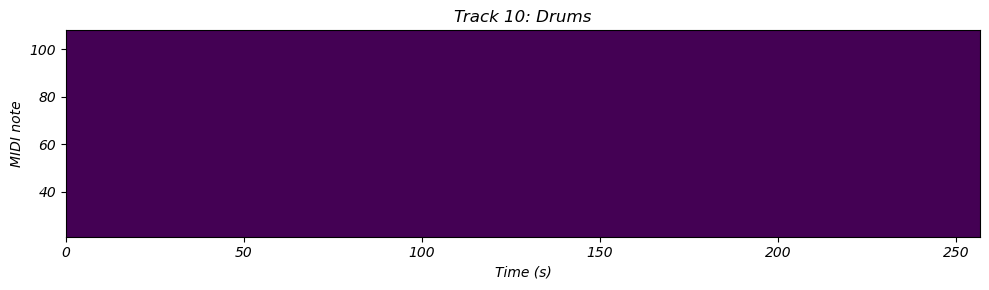

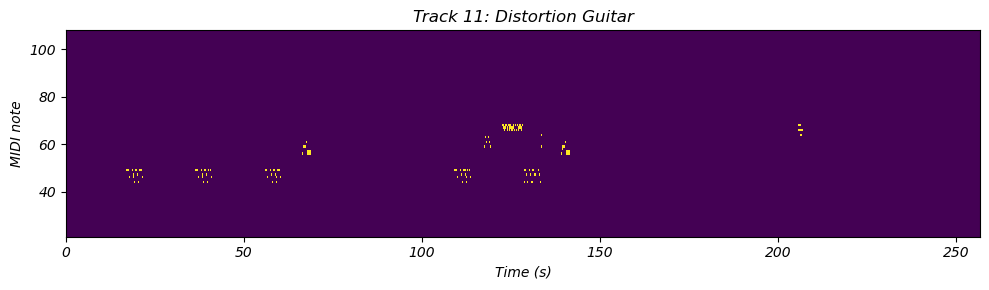

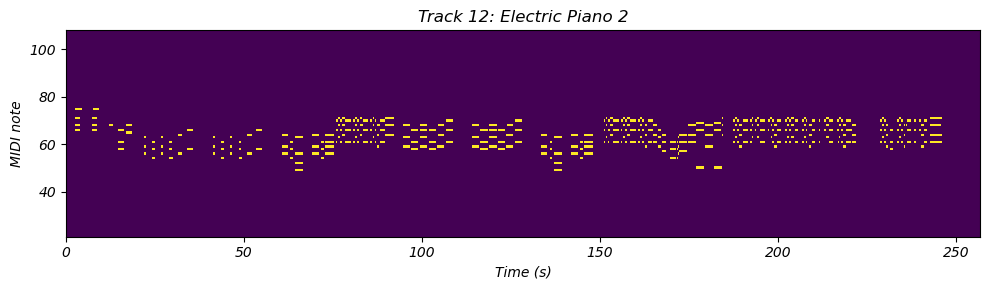

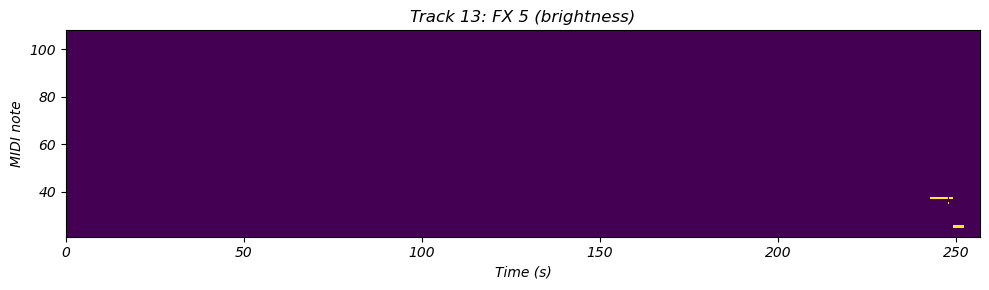

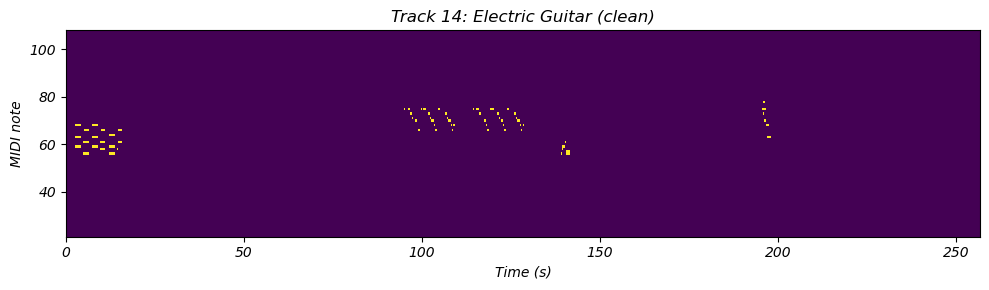

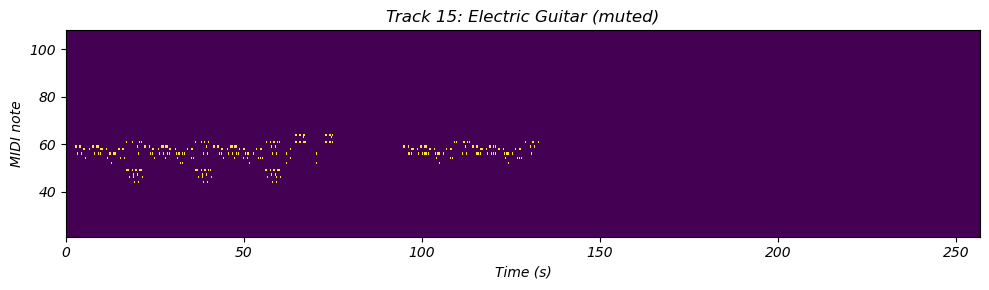

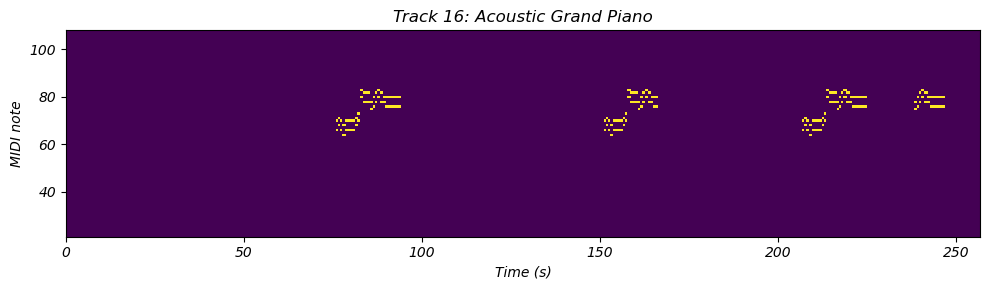

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pretty_midi as pm

midi = pm.PrettyMIDI(str(midi_files[200]))

fs = 20  # frames per second (higher = smoother, slower plotting)
end = midi.get_end_time()
times = np.arange(0, end, 1/fs)

low, high = 21, 108  # piano range (A0–C8). Adjust if you like.

for i, inst in enumerate(midi.instruments):
    roll = inst.get_piano_roll(times=times)              # (128, T)
    roll = (roll[low:high+1] > 0).astype(float)          # on/off view
    extent = [0, times[-1], low, high]

    plt.figure(figsize=(10, 3))
    plt.imshow(roll, origin="lower", aspect="auto", extent=extent, interpolation="nearest")
    name = (pm.program_to_instrument_name(inst.program) 
            if not inst.is_drum else "Drums")
    plt.title(f"Track {i+1}: {name}")
    plt.xlabel("Time (s)")
    plt.ylabel("MIDI note")
    plt.tight_layout()

plt.show()
